# CoVid-19 Tracing

Use this in case it doesn't connect

In [1]:
#! mkdir data

In [2]:
#cd ./data
#%cd ./data/COVID-19

In [3]:
#!git clone https://github.com/CSSEGISandData/COVID-19.git
#!git pull

In [4]:
#%cd ../..

##### We are going to use the data from CSSEGISandData 

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
from geopy.extra.rate_limiter import RateLimiter
from datetime import date, datetime, timedelta
import bokeh
import pandas_bokeh
from pandas_profiling import ProfileReport

### 1. Data acquisition

We must get the files from the source:

In [8]:
date_generated

[datetime.date(2020, 1, 22),
 datetime.date(2020, 1, 23),
 datetime.date(2020, 1, 24),
 datetime.date(2020, 1, 25),
 datetime.date(2020, 1, 26),
 datetime.date(2020, 1, 27),
 datetime.date(2020, 1, 28),
 datetime.date(2020, 1, 29),
 datetime.date(2020, 1, 30),
 datetime.date(2020, 1, 31),
 datetime.date(2020, 2, 1),
 datetime.date(2020, 2, 2),
 datetime.date(2020, 2, 3),
 datetime.date(2020, 2, 4),
 datetime.date(2020, 2, 5),
 datetime.date(2020, 2, 6),
 datetime.date(2020, 2, 7),
 datetime.date(2020, 2, 8),
 datetime.date(2020, 2, 9),
 datetime.date(2020, 2, 10),
 datetime.date(2020, 2, 11),
 datetime.date(2020, 2, 12),
 datetime.date(2020, 2, 13),
 datetime.date(2020, 2, 14),
 datetime.date(2020, 2, 15),
 datetime.date(2020, 2, 16),
 datetime.date(2020, 2, 17),
 datetime.date(2020, 2, 18),
 datetime.date(2020, 2, 19),
 datetime.date(2020, 2, 20),
 datetime.date(2020, 2, 21),
 datetime.date(2020, 2, 22),
 datetime.date(2020, 2, 23),
 datetime.date(2020, 2, 24),
 datetime.date(2020, 2,

In [18]:
files=[]
# The path where the files are is:#
path = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/'
#path = './data/COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/'
# We must get the name of each file. All the are dates, so:

start = start_date=date(2020, 1, 22)
end = date.today()
date_generated = [start + timedelta(days=x) for x in range(0, (end-start).days)]

for dates in date_generated:
    dates=dates.strftime("%m-%d-%Y")+'.csv'
    files.append(dates)

def dataframe(files):
    try:
        datos=pd.DataFrame()
        for file in files:
            filepath=path+file
            df_file=pd.read_csv(filepath)
            df_file['Date']=file[:10]
            datos=pd.concat([datos,df_file],axis=0)
        return datos
    except TimeoutError:
        return dataframe(files)
datos=dataframe(files)

/home/joeldela/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [19]:
df=datos.copy()

### Cleaning data

Data must be cleaned to get a better result. It should be checked periodically.

In [20]:
#We must combine columns and rename them, and drop those columns we won't need
df.rename(columns={'Country/Region':'Country'},inplace=True)
df.rename(columns={'Province/State':'Province'},inplace=True)
df.rename(columns={'Admin2':'City'},inplace=True)
df['Last_Update'].fillna(df['Last Update'],inplace=True)
df['Latitude'].fillna(df['Lat'],inplace=True)
df['Longitude'].fillna(df['Long_'],inplace=True)
df['Country'].fillna(df['Country_Region'],inplace=True)
df['Province'].fillna(df['Province_State'],inplace=True)
df.drop('Lat',inplace=True,axis=1)
df.drop('Long_',inplace=True,axis=1)
df.drop('Country_Region',inplace=True,axis=1)
df.drop('Province_State',inplace=True,axis=1)
df.drop('Last Update',inplace=True,axis=1)
df.drop('Combined_Key',inplace=True,axis=1)
# Some names must be cleaned manually
df.loc[df['Province']=='Fench Guiana','Province']='French Guiana'
df.loc[df['Province']=='Hong Kong','Country'] = 'Hong Kong'
df.loc[df['Province']=='Macau','Country'] = 'Macao'
df.loc[df['Province']=='Taiwan','Country'] = 'Taiwan'
df.loc[df['Province']=='UK','Province'] = np.NaN
df.loc[df['Country'].str.startswith('Tai'),'Country'] = 'Taiwan'
#Some of them are twice but with different names
list_unique_s=list(df['Province'].unique())
list_unique_s.remove(np.NaN)
for state in list_unique_s:
    filtro=df['Province'].str.contains(state).fillna(False)
    unicos=df.loc[filtro,'Province'].unique()
    if len(unicos)>1:
        df.loc[filtro,'Province']=unicos[0]

list_unique_c=list(df['Country'].unique())
for country in list_unique_c:
    filtro=df['Country'].str.contains(country).fillna(False)
    unicos=df.loc[filtro,'Country'].unique()
    if len(unicos)>1:
        df.loc[filtro,'Country']=unicos[0]
        
# In some rows the Country is placed in the 'Province/State' column
for i in range(df.shape[0]):
    if df.iloc[i,0]==df.iloc[i,1]:
        df.iloc[i,0]=np.NaN
    else:
        continue

/home/joeldela/anaconda3/lib/python3.7/site-packages/pandas/core/strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


#### Data Localization

In [21]:
df_aux=df.copy()
df_aux=df_aux.reset_index().drop('index',axis=1)

We may get the Address based on the coordimates:

The loop to use is:

```python
geolocator = Nominatim(user_agent="CoVid-19",timeout=10)
geocode = RateLimiter(geolocator.reverse, min_delay_seconds=1)
for i in range(df_aux.shape[0]):
    try:
        if not pd.isnull(df_aux['Address'][i]):
            df_aux['Address'][i]
        elif pd.isnull(df_aux['Latitude'][i]):
            df_aux['Address'][i]=np.NaN
        else:
            lat=df_aux['Latitude'][i]
            lon=df_aux['Longitude'][i]
            df_aux['Address'][i]=str(geocode(str(lat)+', '+str(lon)))
    except TypeError:
        continue
```

In [22]:
df_aux['Address']=np.NaN
def locate(row):
    geolocator = Nominatim(user_agent="CoVid-19")
    geocode = RateLimiter(geolocator.reverse, min_delay_seconds=1)
    try:
        if not pd.isnull(df_aux['Address'][i]):
            df_aux['Address'][i]
        elif pd.isnull(df_aux['Latitude'][i]):
            df_aux['Address'][i]=np.NaN
        else:
            lat=df_aux['Latitude'][i]
            lon=df_aux['Longitude'][i]
            df_aux['Address'][i]=str(geocode(str(lat)+', '+str(lon)))
    except:
        None

df_aux.apply(lambda row: locate(row),axis=1)

/home/joeldela/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/joeldela/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


0        None
1        None
2        None
3        None
4        None
         ... 
17861    None
17862    None
17863    None
17864    None
17865    None
Length: 17866, dtype: object

In [23]:
df_aux['Location']=np.nan
for i in range(df.shape[0]):
    try:
        if pd.isnull(df_aux['Address'][i]):
            df_aux['Address'][i]
        elif any(i.isdigit() for i in df_aux['Address'][i].split(',')[-2]):
            df_aux['Location'][i]=df_aux['Address'][i].split(',')[-3]
        else:
            df_aux['Location'][i]=df_aux['Address'][i].split(',')[-2]
    except IndexError:
        df_aux['Address'][i]

/home/joeldela/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [24]:
df_aux

,Active,City,Confirmed,Country,Date,Deaths,FIPS,Last_Update,Latitude,Longitude,Province,Recovered,Address,Location
0,NaN,NaN,1.0,Mainland China,01-22-2020,NaN,NaN,1/22/2020 17:00,NaN,NaN,Anhui,NaN,NaN,NaN
1,NaN,NaN,14.0,Mainland China,01-22-2020,NaN,NaN,1/22/2020 17:00,NaN,NaN,Beijing,NaN,NaN,NaN
2,NaN,NaN,6.0,Mainland China,01-22-2020,NaN,NaN,1/22/2020 17:00,NaN,NaN,Chongqing,NaN,NaN,NaN
3,NaN,NaN,1.0,Mainland China,01-22-2020,NaN,NaN,1/22/2020 17:00,NaN,NaN,Fujian,NaN,NaN,NaN
4,NaN,NaN,NaN,Mainland China,01-22-2020,NaN,NaN,1/22/2020 17:00,NaN,NaN,Gansu,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17861,50.0,NaN,50.0,Uzbekistan,03-24-2020,0.0,NaN,2020-03-24 23:37:15,41.377491,64.585262,NaN,0.0,NaN,NaN
17862,69.0,NaN,84.0,Venezuela,03-24-2020,0.0,NaN,2020-03-24 23:37:15,6.423800,-66.589700,NaN,15.0,NaN,NaN
17863,117.0,NaN,134.0,Vietnam,03-24-2020,0.0,NaN,2020-03-24 23:37:15,14.058324,108.277199,NaN,17.0,NaN,NaN
17864,3.0,NaN,3.0,Zambia,03-24-2020,0.0,NaN,2020-03-24 23:37:15,-13.133897,27.849332,NaN,0.0,NaN,NaN


In [29]:
data_covid=df_aux[['Date','City','Province','Country','Active','Confirmed','Deaths','Recovered','Latitude','Longitude','Address','Location']]
data_covid.loc[:,'Date']=pd.to_datetime(data_covid.loc[:,'Date']).dt.date
ts_covid=data_covid.set_index('Date')

/home/joeldela/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


##### Now we can proceed with the data visualization

In [30]:
ts_covid.drop_duplicates(inplace=True)

In [31]:
pais='Spain'
filtro_pais=ts_covid['Country']==pais
spain=ts_covid[filtro_pais]
spain

,City,Province,Country,Active,Confirmed,Deaths,Recovered,Latitude,Longitude,Address,Location
Date,,,,,,,,,,,
2020-02-01,NaN,NaN,Spain,NaN,1.0,0.0,0.0,NaN,NaN,NaN,NaN
2020-02-09,NaN,NaN,Spain,NaN,2.0,0.0,0.0,NaN,NaN,NaN,NaN
2020-02-15,NaN,NaN,Spain,NaN,2.0,0.0,2.0,NaN,NaN,NaN,NaN
2020-02-25,NaN,NaN,Spain,NaN,6.0,0.0,2.0,NaN,NaN,NaN,NaN
2020-02-26,NaN,NaN,Spain,NaN,13.0,0.0,2.0,NaN,NaN,NaN,NaN
2020-02-27,NaN,NaN,Spain,NaN,15.0,0.0,2.0,NaN,NaN,NaN,NaN
2020-02-28,NaN,NaN,Spain,NaN,32.0,0.0,2.0,NaN,NaN,NaN,NaN
2020-02-29,NaN,NaN,Spain,NaN,45.0,0.0,2.0,NaN,NaN,NaN,NaN
2020-03-01,NaN,NaN,Spain,NaN,84.0,0.0,2.0,40.000000,-4.00000,NaN,NaN


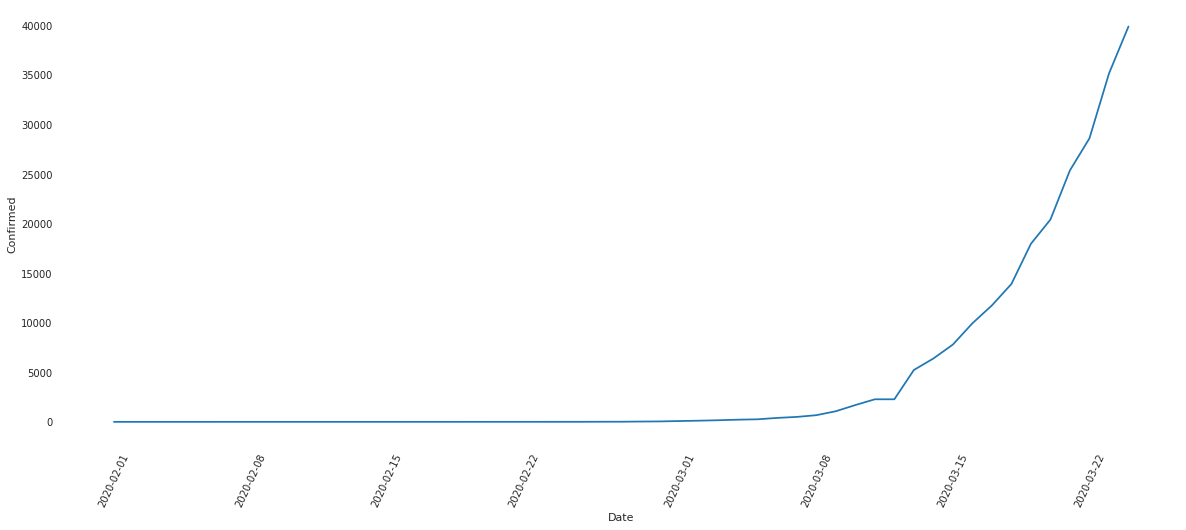

In [32]:
plt.figure(figsize=(20,8))
plt.xticks(rotation=65)
sns.lineplot(x=spain.index,y='Confirmed',data=spain)

In [42]:
spain_diff=spain.loc[:,'Confirmed'].diff()

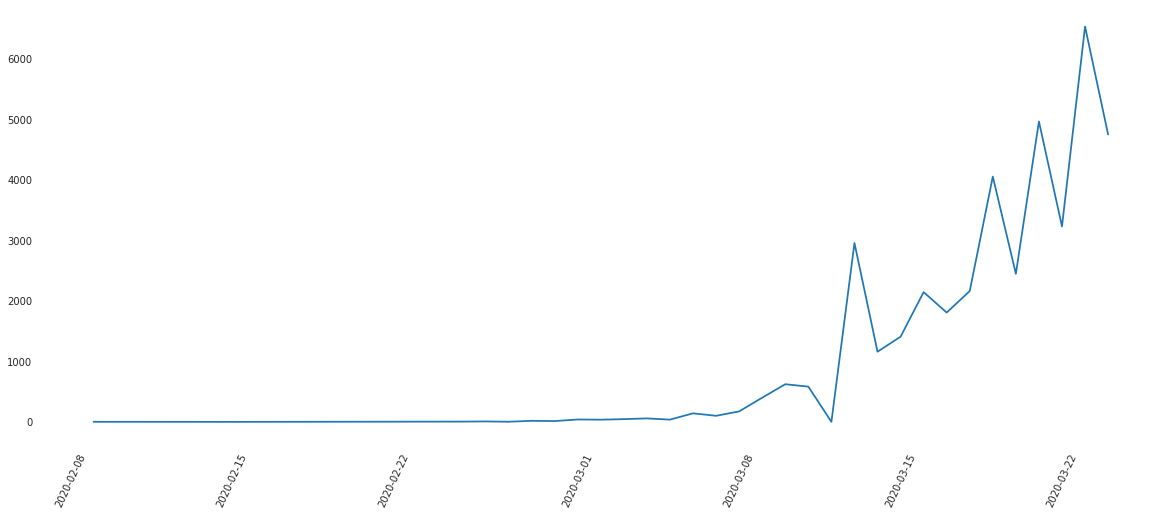

In [45]:
plt.figure(figsize=(20,8))
plt.xticks(rotation=65)
sns.lineplot(data=spain_diff)